## GBDT

In [47]:
# データ準備
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import numpy as np
df = sns.load_dataset('titanic')
df.dropna(inplace = True)
# X,yを作成
X = df.loc[:, (df.columns != 'survived') & (df.columns != 'alive')]
y = df['survived']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')
X = oe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### XGBoost

In [9]:
!pip install xgboost


[notice] A new release of pip is available: 23.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [23]:
from xgboost import XGBClassifier

# importance_typeはfeature_importance_を決める指標　デフォルトだと頻度（weight）になってる
xgb = XGBClassifier(learning_rate=0.01, 
                eval_metric='auc',
                early_stopping_rounds=10,
                importance_type='total_gain',
                random_state=0)


# 毎回のイテレーションでeval_setで AUCを計算して、
# early_stipping_roundsに指定した回数、精度の改善が見られなかったら学習を止める

# 以下ではtestをeval_setで与えているが、
# 本来は、hold-outでtrainデータを分割し、valデータも別途用意する
# そしてtest_dataで最後のモデルの評価を行う
# さらにいうと、early-stoppingを設定するということは、
# そのデータに対して最も精度が高いものを良しとする形を取るためeval_setに与えたデータに過学習してしまう状態に陥ることがある。
# 実際にはcvを使って5foldなどで5回に分けてeval_setに入れる値も変えるべし
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose = True)

[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103
[10]	validation_0-auc:0.88622


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None,
              importance_type='total_gain', interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

In [26]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)

# eval_setでtestデータを使ってるので、比較的高めに値が出る
print(f"xgboost AUC:{roc_auc_score(y_test, y_pred_xgb[:,1])}")

xgboost AUC:0.8990384615384616


In [27]:
xgb.feature_importances_

array([0.        , 0.        , 0.10952041, 0.        , 0.        ,
       0.22573484, 0.        , 0.        , 0.        , 0.59854376,
       0.05928717, 0.        , 0.00691384], dtype=float32)

<AxesSubplot:>

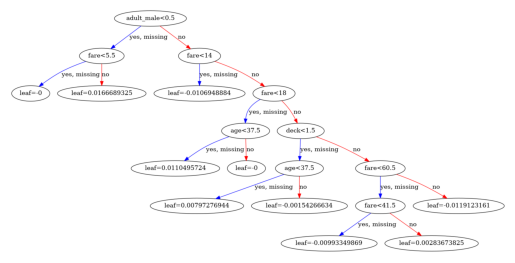

In [28]:
# 各木の描画
import xgboost
xgboost.plot_tree(xgb, num_trees=1)

# LGBM

In [32]:
# !pip install lightgbm
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type = 'goss', max_depth = 5,  random_state=0)

eval_set = [(X_test, y_test)] # 実務ではvalデータ用意しよう
# 各イテレーションで実行されるもの

callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10)) #10連続で評価指標が改善しなくなるまで
callbacks.append(lgb.log_evaluation())
lgbmc.fit(X_train, y_train, eval_set = eval_set, callbacks = callbacks)


[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [35]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
#XGBoost同様にx_testに過学習した結果となっているため、
# eval_setを実際には考えないといけない
print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:,1])}")

light gbm AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

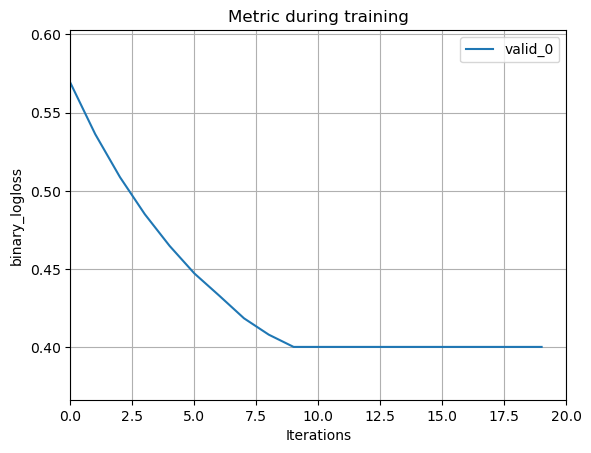

In [38]:
# 学習曲線
lgb.plot_metric(lgbmc)

# 実際の業務ではどのように考察するか
# - かなり急降下で損失が下がっているので、learning_rateを下げながら経過を見てみるなど
# - 詳しくはHPチューニングの話

<AxesSubplot:>

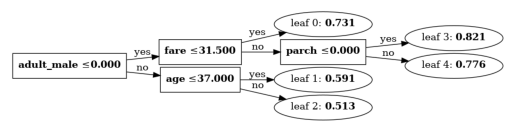

In [40]:
lgb.plot_tree(lgbmc, tree_index=0)

### CatBoost

In [42]:
# !pip install catboosts

In [51]:
df = sns.load_dataset('titanic')
df.dropna(inplace = True)
# X,yを作成
X = df.loc[:, (df.columns != 'survived') & (df.columns != 'alive')]
y = df['survived']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1 to 889
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       182 non-null    int64   
 1   sex          182 non-null    object  
 2   age          182 non-null    float64 
 3   sibsp        182 non-null    int64   
 4   parch        182 non-null    int64   
 5   fare         182 non-null    float64 
 6   embarked     182 non-null    object  
 7   class        182 non-null    category
 8   who          182 non-null    object  
 9   adult_male   182 non-null    bool    
 10  deck         182 non-null    category
 11  embark_town  182 non-null    object  
 12  alone        182 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(3), object(4)
memory usage: 15.4+ KB


In [54]:
cat_cols = X.select_dtypes(exclude= np.number).columns.tolist()


In [55]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [59]:
from catboost import CatBoostClassifier
# CatBoostは、引数cat_featuresにカテゴリカル変数のカラム名を入れることで、
# 自動でtarget encodingしてくれる
cbc = CatBoostClassifier(iterations = 1000, learning_rate=0.01, cat_features=cat_cols)

eval_set = [(X_test,y_test)]
cbc.fit(X_train, y_train, eval_set= eval_set, early_stopping_rounds=10, verbose = True)


0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 1.16ms	remaining: 1.16s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 5.38ms	remaining: 2.68s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 11.6ms	remaining: 3.86s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 13.9ms	remaining: 3.45s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 18.9ms	remaining: 3.76s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 22.1ms	remaining: 3.67s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 27.5ms	remaining: 3.9s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 34.4ms	remaining: 4.27s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 39.2ms	remaining: 4.31s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 42.9ms	remaining: 4.24s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 48.4ms	remaining: 4.36s
11:	learn: 0.6349835	test: 0.6211657	best:

In [63]:
cbc.predict_proba(X_test)
y_pred_cbc = cbc.predict_proba(X_test)
print(f"catboost gbm AUC: {roc_auc_score(y_test, y_pred_cbc[:,1])}")

catboost gbm AUC: 0.8942307692307693


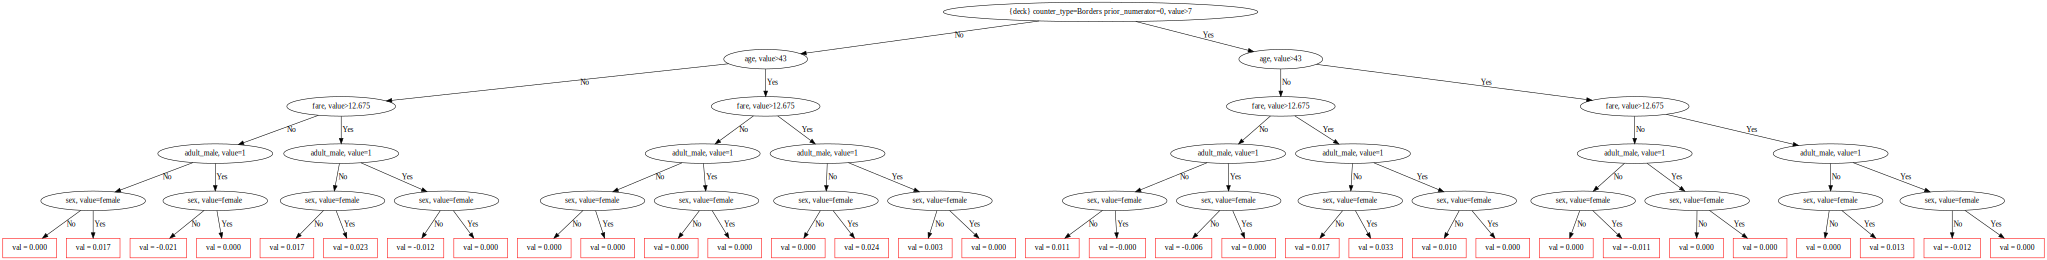

In [71]:
from catboost import Pool
pool = Pool(X_train, y_train, cat_features=cat_cols)
cbc.plot_tree(tree_idx=1 ,pool = pool)